<a href="https://colab.research.google.com/github/nguyenbac5299/Caculator/blob/master/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

#Features

In [ ]:
# Import trainning and validation sets
!unzip '/content/drive/MyDrive/ColabNotebooks/sources/DataScience/Data/data/bluebook-for-bulldozers.zip' -d '/content/'

In [ ]:
df= pd.read_csv('/content/bluebook-for-bulldozers/TrainAndValid.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
fig, ax= plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [ ]:
df.saledate[:10]

In [ ]:
df.SalePrice.plot.hist()

##Parsing dates

In [ ]:
df= pd.read_csv('/content/bluebook-for-bulldozers/TrainAndValid.csv', parse_dates=['saledate'])
df.saledate.dtype

In [ ]:
df.saledate[:10]

In [ ]:
fig, ax= plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

##Sort DataFrame by saledate

In [ ]:
#when working with time series data, it's a good idea to sort it by date

# Sort dataframe in date order
df.sort_values(by=['saledate'], inplace= True, ascending= True)
df.saledate.head()

##Make a copy of the original DataFrame

In [ ]:
df_tmp= df.copy()

##Add datetime parameter for saledate column

In [ ]:
df_tmp['saleYear']= df_tmp.saledate.dt.year
df_tmp['saleMonth']= df_tmp.saledate.dt.month
df_tmp['day']= df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek']= df_tmp.saledate.dt.day_of_week
df_tmp['saleDayOfYear']= df_tmp.saledate.dt.day_of_year

In [ ]:
df_tmp.head().T

In [ ]:
df_tmp.drop('saledate', axis=1, inplace=True)

In [ ]:
df_tmp.state.value_counts()

# Modelling

In [ ]:
# Let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)
df.info()

In [ ]:
df.isna().sum()

##Convert string to categories

In [ ]:
pd.api.types.is_string_dtype(df_tmp['UsageBand'])

In [ ]:
df_tmp.items()

In [ ]:
for label, content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    print(label)

In [ ]:
for label, content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    df_tmp[label] = content.astype('category').cat.as_ordered()

In [ ]:
df_tmp.info()

In [ ]:
df_tmp.state.cat.categories

In [ ]:
df_tmp.state.cat.codes

In [ ]:
df_tmp.head().T

##Save preprocessed data

In [ ]:
# export current tmp data frame
df_tmp.to_csv('/content/bluebook-for-bulldozers/train_tmp.csv')

##Fill missing values

###Fill numerical missing values first

In [ ]:
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

In [ ]:
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      # Add binary column to indicate whether sample had missing value
      df_tmp[label+'_is_missing']= pd.isnull(content)
      df_tmp[label]= content.fillna(content.median())

In [ ]:
df_tmp.auctioneerID_is_missing.value_counts()

In [ ]:
df_tmp.isna().sum()

###Filling and turning categorical variables into numbers

In [ ]:
for label, content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

In [ ]:
pd.Categorical(df_tmp.state).dtype

In [ ]:
pd.Categorical(df_tmp.state).codes

In [ ]:
pd.Categorical(df_tmp.UsageBand).codes

In [ ]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
    # Add binary column to indicate whether sample has missing data
    df_tmp[label+'_is_missing']= pd.isnull(content)
    df_tmp[label]= pd.Categorical(content).codes +1

In [ ]:
df_tmp.info()

In [ ]:
df_tmp.head().T

### test model with full data

In [ ]:
%%time
# Instantiate model
model= RandomForestRegressor(n_jobs=-1,
                             random_state=42)

# Fit the model
model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])


In [ ]:
model.score(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

##Split data into train/validation sets

In [ ]:
df_tmp.saleYear

In [ ]:
df_tmp.saleYear.value_counts()

In [ ]:
df_val= df_tmp[df_tmp.saleYear==2012]
df_train= df_tmp[df_tmp.saleYear!= 2012]
len(df_val), len(df_train)

In [ ]:
# Split data into X, y

X_train, y_train= df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_val, y_val= df_val.drop('SalePrice', axis=1), df_val['SalePrice']

len(X_train), len(y_train), len(X_val), len(y_val)

##Building a evaluation function

In [ ]:

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle (y_test, y_preds):
  return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_score(model):
  train_preds= model.predict(X_train)
  val_preds= model.predict(X_val)
  score={'Training MAE': mean_absolute_error(y_train, train_preds),
         'valid MAE': mean_absolute_error(y_val, val_preds),
         'Training RMSLE': rmsle(y_train, train_preds),
         'Valid RMSLE': rmsle(y_val, val_preds),
         'Training R^2': r2_score(y_train, train_preds),
         'Valid R^2': r2_score(y_val, val_preds)}
  return score

##Testing our model on a subset (to tune the hyperparameters)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Change max_samples value
model= RandomForestRegressor(n_jobs=-1,
                             random_state=42,
                             max_samples= 10000)

In [ ]:
%%time
# Cutting down on the max number of samples 
model.fit(X_train, y_train)

CPU times: user 35.6 s, sys: 433 ms, total: 36 s
Wall time: 23.5 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [ ]:
train_preds= model.predict(X_train)
val_preds= model.predict(X_val)

In [ ]:
mean_absolute_error(y_train, train_preds)

5561.396858734807

In [ ]:
rmsle(y_train, train_preds)

0.2577477569876176

In [ ]:
mean_absolute_error(y_val, val_preds)

7181.745755638123

In [ ]:
rmsle(y_val, val_preds)

0.293595185306081

In [ ]:
show_score(model)

{'Training MAE': 5561.396858734807,
 'valid MAE': 7181.745755638123,
 'Training RMSLE': 0.2577477569876176,
 'Valid RMSLE': 0.293595185306081,
 'Training R^2': 0.8607116981822567,
 'Valid R^2': 0.8316902392066935}

##Hyperparameter tuning with RandomizedSearCV

In [ ]:
model._get_param_names()

['bootstrap',
 'ccp_alpha',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Different RandomForestRegressor hyperparameter
rf_grid={'n_estimators': np.arange(10, 100, 10),
         'max_depth': [None, 10, 100, 1000],
         'min_samples_split':np.arange(2,20,2),
         'min_samples_leaf':np.arange(1,20,2),
         'max_features':[1,'sqrt','auto'],
         'max_samples':[10000]}

rs_model= RandomizedSearchCV(RandomForestRegressor(),
                             param_distributions=rf_grid,
                             n_iter=3,
                             cv=5,
                             verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=3,
                   param_distributions={'max_depth': [None, 10, 100, 1000],
                                        'max_features': [1, 'sqrt', 'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [ ]:
rs_model.best_params_

{'n_estimators': 20,
 'min_samples_split': 16,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 100}

In [ ]:
# Evaluate the RandomizedSearch model
show_score(rs_model)

{'Training MAE': 7574.698155151681,
 'valid MAE': 9039.600045160292,
 'Training RMSLE': 0.33508351673587217,
 'Valid RMSLE': 0.3714290874964333,
 'Training R^2': 0.7600624324182267,
 'Valid R^2': 0.7588610191703533}

##Train a model with the best hyperparameters

In [ ]:
%%time
#Most ideal hyperparameter
ideal_model= RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=1,
                                   min_samples_split=14,
                                   max_features=0.5,
                                   n_jobs=-1,
                                   max_samples=None,
                                   random_state=42)
#Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 2min 33s, sys: 205 ms, total: 2min 33s
Wall time: 1min 36s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [ ]:
show_score(ideal_model)

{'Training MAE': 2946.8483786146962,
 'valid MAE': 5963.098428944584,
 'Training RMSLE': 0.14446831828269255,
 'Valid RMSLE': 0.2455197857548867,
 'Training R^2': 0.9589267192100979,
 'Valid R^2': 0.8816029704165416}

#Make predictions on test data

In [ ]:
# Import test dataset
df_test= pd.read_csv('/content/bluebook-for-bulldozers/Test.csv', parse_dates=['saledate'])

In [ ]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,5/3/2012 0:00,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,5/10/2012 0:00,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,5/10/2012 0:00,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,5/10/2012 0:00,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,5/10/2012 0:00,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [ ]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 1834 non-null   object 
 8   saledate                  12457 non-null  object 
 9   fiModelDesc               12457 non-null  object 
 10  fiBaseModel               12457 non-null  object 
 11  fiSecondaryDesc           8482 non-null   object 
 12  fiModelSeries             2006 non-null   object 
 13  fiModelDescriptor         3024 non-null   object 
 14  Produc

##Preprocessing the data(getting the test dataset in the same format as our training dataset)

In [ ]:
def preprocess_data(df):
  df['saleYear']= df.saledate.dt.year
  df['saleMonth']= df.saledate.dt.month
  df['day']= df.saledate.dt.day
  df['saleDayOfWeek']= df.saledate.dt.day_of_week
  df['saleDayOfYear']= df.saledate.dt.day_of_year

  df.drop('saledate', axis=1, inplace=True)
  #Fill the numeric rows with median
  for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
      if pd.isnull(content).sum():
        df[label+'_is_missing']= pd.isnull(content)
        df[label]= content.fillna(content.median())

    # Fill categorical missing data
    if not pd.api.types.is_numeric_dtype(content):
      df[label+'_is_missing']= pd.isnull(content)
      df[label]= pd.Categorical(content).codes+1

  return df

In [ ]:
df_test= preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [ ]:
# We cant find how the columns differ using sets

set(X_train.columns)- set(df_test.columns)

{'auctioneerID_is_missing'}

In [ ]:
# manually adjust df_test to have auctioneerID_is_missing
df_test['auctioneerID_is_missing']= False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [ ]:
# make prediction on test data
test_preds= ideal_model.predict(df_test)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
test_preds

array([23656.03479596, 24735.17942629, 52467.10220894, ...,
       13859.18614045, 23198.02467855, 33025.3789073 ])

In [ ]:
df_preds= pd.DataFrame()
df_preds['SalesID']= df_test['SalesID']
df_preds['SalePrice']= test_preds
df_preds

,SalesID,SalePrice
0,1227829,23656.034796
1,1227844,24735.179426
2,1227847,52467.102209
3,1227848,70904.998988
4,1227863,46987.436956
...,...,...
12452,6643171,48914.577754
12453,6643173,16994.742130
12454,6643184,13859.186140
12455,6643186,23198.024679


In [ ]:
df_preds.to_csv('/content/test_predictions.csv')

#Feature Importance

In [ ]:
# Find feature importance of best model
ideal_model.feature_importances_

array([3.29131508e-02, 1.78694060e-02, 3.98175951e-02, 1.60089049e-03,
       3.32361489e-03, 2.11617049e-01, 3.04786604e-03, 1.10733567e-03,
       4.32503106e-02, 4.56990418e-02, 6.22889932e-02, 4.34317385e-03,
       1.65752885e-02, 1.60314314e-01, 4.65032343e-02, 5.93425591e-03,
       1.14472630e-03, 2.22435822e-03, 2.78359195e-03, 5.18763735e-02,
       7.01285229e-04, 2.90008444e-05, 1.19616398e-03, 2.00581261e-04,
       1.17495045e-03, 2.44139914e-05, 2.05122188e-03, 6.20253008e-03,
       1.81542137e-04, 2.45889054e-03, 4.97815647e-03, 3.63259113e-03,
       2.92046478e-03, 5.02320953e-04, 2.86187520e-04, 6.36143085e-03,
       8.53222997e-04, 1.70651334e-02, 8.19522223e-04, 1.79816634e-03,
       4.97226236e-04, 8.11181537e-04, 2.54577285e-03, 5.78885988e-04,
       7.09402933e-04, 3.60972051e-04, 2.46047689e-04, 1.63958848e-03,
       8.56525102e-04, 2.86465653e-04, 3.40985374e-04, 7.41179618e-02,
       3.77158269e-03, 5.60599490e-03, 2.92541561e-03, 9.86812881e-03,
      

In [ ]:
def plot_feature(columns, importance, n=20):
  df= (pd.DataFrame({'feature': columns,
                     'feature_importance': importance})
  .sort_values('feature_importance', ascending=False)
  .reset_index(drop=True))

  # Plot the dataframe
  fig, ax= plt.subplots()
  ax.barh(df['feature'][:n], df['feature_importance'][:n])
  ax.set_ylabel('feature')
  ax.set_xlabel('feature importance')
  ax.invert_yaxis()

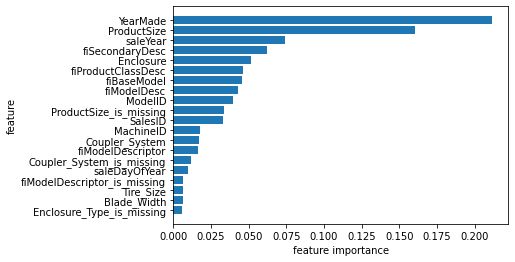

In [ ]:
plot_feature(X_train.columns, ideal_model.feature_importances_)